# Centralised SVM

In this example I use CVXPY to train a SVM classifier with $\ell_2-regularization$. We are given data $(x_i,y_i), i=1,\ldots, m$. The $x_i \in {\bf R}^n$ are feature vectors, while the $y_i \in \{\pm 1\}$ are associated boolean outcomes. The goal is to construct a good linear classifier $\hat y = {\rm sign}(\beta^T x - v)$. I find the parameters $\beta,v$ by minimizing the (convex) function

$$f(\beta,v) = \sum_i \left(1 - y_i ( \beta^T x_i-v) \right)_+ + \lambda
\| \beta\|_2 + \lambda v^2$$
The first term is the average hinge loss. The scalar $\lambda \geq 0$ is a (regularization) parameter. Minimizing $f(\beta,v)$ simultaneously selects features and fits the classifier.

In [1]:
import pandas as pd
import numpy as np
import csv
import pandas as pd
import cvxpy as cp
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.metrics import confusion_matrix

from utils import *

###  Breast Cancer dataset

In [2]:
X_train, X_test, y_train, y_test = load_breast_test_train_dataset()

### Loan Clients dataset

In [3]:
X_train, X_test, y_train, y_test = load_Loan_test_train_dataset()

In [4]:
X_train.shape

(21934, 50)

### Normalize data

In [5]:
normalizer_ = Normalizer()
normalizer_.fit(X_train)

X_train = normalizer_.transform(X_train)
X_test = normalizer_.transform(X_test)

In [4]:
# scaler = StandardScaler()
# scaler.fit(X_train)

# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)

In [6]:
def generate_A_mat(X, y):
    
    # Add ONE at the end of all x-data vectors
    X = np.concatenate((X, np.ones((X.shape[0], 1))), axis = 1)
    
    # -1 * y_vector
    minus_y = np.multiply(-1, y).reshape(-1, 1)
    
    # Componentiwise multiplication
    A = np.multiply(minus_y, X)
    return A

In [57]:
A_train = generate_A_mat(X_train, y_train)
A_test = generate_A_mat(X_test, y_test)

In [33]:
A_train.shape

(21934, 51)

In [28]:
def predict(X, weights):
    w = weights[:-1]
    b = weights[-1]
    return np.sign(X.dot(w) + b)    

### Optimization

In [29]:
# Problem Formulation

# m, n = X_train.shape

# beta = cp.Variable((n, 1))
# v = cp.Variable((1,1))
# lambd = cp.Parameter(nonneg=True)

# loss = cp.sum(cp.pos(1 - cp.multiply(y_train, X_train*beta - v)))
# reg = cp.sum_squares(beta)

# prob = cp.Problem(cp.Minimize(loss/m + lambd*reg))

In [30]:
# Problem Formulation

m, n = X_train.shape

x = cp.Variable((n+1, 1))
lambd = cp.Parameter(nonneg=True)

loss = cp.sum(cp.pos(1 + A_train*x))
reg = cp.sum_squares(x)

prob = cp.Problem(cp.Minimize(loss + lambd*reg))

In [ ]:
# np.linspace(0, 1e-3, 15)

In [77]:
# Minimization for different LAMBDA values

np.random.seed(123)

TRIALS = 10
train_error = np.zeros(TRIALS)
test_error = np.zeros(TRIALS)
train_acc = np.zeros(TRIALS)
test_acc = np.zeros(TRIALS)

lambda_vals = np.linspace(1e-2, 15, TRIALS)
# lambda_vals = [5e-10, 5e-8, 5e-6, 0.0003, 0.0001, 0.003, 0.05, 10, 20]
x_vals = [] 

for i in range(TRIALS):
    lambd.value = lambda_vals[i]
    prob.solve(verbose=True, solver='ECOS') #solver='ECOS', 'OSQP'
    print(i, end='\t')
#     y_pred_tr = predict(X_train, weights=x.value)
#     y_pred_te = predict(X_test, weights=x.value)
    y_pred_tr = np.sign(A_train.dot(x.value))
    y_pred_te = np.sign(A_test.dot(x.value))
    train_error[i] = (y_train != y_pred_tr).sum()/len(y_train)
    test_error[i] = (y_test != y_pred_te).sum()/len(y_test)
    train_acc[i] = accuracy_score(y_train, y_pred_tr)
    test_acc[i] = accuracy_score(y_test, y_pred_te)
    x_vals.append(x.value)


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +8.425e+03  +1.335e+05  +2e+06  8e-01  3e+01  1e+00  4e+01    ---    ---    2  2  - |  -  - 
 1  +9.410e+03  +1.274e+05  +2e+06  7e-01  3e+01  9e+00  4e+01  0.1273  9e-01   2  1  1 |  0  0
 2  +1.289e+04  +7.706e+04  +1e+06  2e-01  2e+01  7e+01  3e+01  0.3181  6e-01   2  1  1 |  0  0
 3  +1.291e+04  +7.653e+04  +1e+06  2e-01  2e+01  9e+01  3e+01  0.0291  9e-01   2  1  1 |  0  0
 4  +1.316e+04  +6.796e+04  +1e+06  2e-01  1e+01  3e+02  3e+01  0.2860  8e-01   2  1  1 |  0  0
 5  +1.316e+04  +6.419e+04  +1e+06  1e-01  1e+01  4e+02  3e+01  0.0594  7e-01   2  1  1 |  0  0
 6  +1.313e+04  +6.401e+04  +1e+06  1e-01  1e+01  5e+02  3e+01  0.0284  1e+00   2  1  1 |  0  0
 7  +1.335e+04  +2.358e+04  +6e+05  1e-02  2e+00  1e+03  1e+01  0.8495  3e-01   2  1  2 |  0  0
 8  +1.364e+04  +2.003e+04  +4e+05  6e-03  7e-

36  +1.588e+04  +1.588e+04  +1e+01  2e-06  9e-06  1e-05  3e-04  0.7233  8e-02   4  2  2 |  0  0
37  +1.588e+04  +1.588e+04  +4e+00  6e-07  3e-06  4e-06  9e-05  0.7147  7e-02   4  2  2 |  0  0
38  +1.588e+04  +1.588e+04  +9e-01  2e-07  7e-07  1e-06  2e-05  0.8589  1e-01   3  2  2 |  0  0
39  +1.588e+04  +1.588e+04  +3e-01  4e-08  2e-07  3e-07  6e-06  0.7325  2e-02   4  2  2 |  0  0
40  +1.588e+04  +1.588e+04  +5e-02  9e-09  4e-08  5e-08  1e-06  0.9890  2e-01   3  2  2 |  0  0
41  +1.588e+04  +1.588e+04  +1e-03  2e-10  1e-09  1e-09  3e-08  0.9725  6e-04   3  2  2 |  0  0
42  +1.588e+04  +1.588e+04  +3e-05  5e-12  2e-11  3e-11  7e-10  0.9805  1e-04   3  1  1 |  0  0

OPTIMAL (within feastol=2.3e-11, reltol=1.8e-09, abstol=2.9e-05).
Runtime: 6.059189 seconds.

1	
ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +8.425e+03  +7.020e+04  +9e+05  8e-01  3e+

34  +1.590e+04  +1.590e+04  +6e-05  1e-11  7e-11  6e-11  1e-09  0.9800  4e-04   3  2  2 |  0  0

OPTIMAL (within feastol=6.9e-11, reltol=3.8e-09, abstol=6.0e-05).
Runtime: 4.891168 seconds.

3	
ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +8.425e+03  +7.020e+04  +9e+05  8e-01  2e+01  1e+00  2e+01    ---    ---    2  1  - |  -  - 
 1  +9.454e+03  +6.931e+04  +9e+05  8e-01  2e+01  2e+00  2e+01  0.0245  9e-01   2  1  1 |  0  0
 2  +1.088e+04  +6.720e+04  +9e+05  8e-01  1e+01  7e+00  2e+01  0.1312  8e-01   3  2  2 |  0  0
 3  +1.466e+04  +4.354e+04  +7e+05  4e-01  4e+00  3e+01  2e+01  0.3537  5e-01   3  2  2 |  0  0
 4  +1.546e+04  +2.823e+04  +5e+05  2e-01  1e+00  4e+01  1e+01  0.4396  3e-01   2  1  2 |  0  0
 5  +1.581e+04  +2.198e+04  +3e+05  9e-02  4e-01  2e+01  7e+00  0.9131  6e-01   3  1  2 |  0  0
 6  +1.597e+04  +1.828e+04  +1e+05  3e-02  1e

11  +1.592e+04  +1.719e+04  +8e+04  2e-02  4e-02  4e+00  2e+00  0.4135  3e-01   2  2  2 |  0  0
12  +1.591e+04  +1.705e+04  +7e+04  1e-02  4e-02  3e+00  2e+00  0.1985  5e-01   2  3  2 |  0  0
13  +1.590e+04  +1.689e+04  +6e+04  1e-02  3e-02  3e+00  1e+00  0.2828  6e-01   2  2  3 |  0  0
14  +1.590e+04  +1.683e+04  +6e+04  1e-02  3e-02  1e+00  1e+00  0.5699  9e-01   2  3  2 |  0  0
15  +1.590e+04  +1.667e+04  +5e+04  9e-03  3e-02  8e-01  1e+00  0.3285  5e-01   3  2  2 |  0  0
16  +1.588e+04  +1.600e+04  +8e+03  1e-03  4e-03  1e-01  2e-01  0.8821  5e-02   3  2  2 |  0  0
17  +1.590e+04  +1.599e+04  +6e+03  1e-03  4e-03  4e-02  1e-01  0.6013  6e-01   3  4  4 |  0  0
18  +1.590e+04  +1.592e+04  +2e+03  3e-04  1e-03  1e-02  4e-02  0.7697  5e-02   4  3  3 |  0  0
19  +1.590e+04  +1.591e+04  +8e+02  1e-04  6e-04  3e-03  2e-02  0.7193  3e-01   3  3  3 |  0  0
20  +1.590e+04  +1.591e+04  +5e+02  7e-05  4e-04  1e-03  1e-02  0.6037  3e-01   5  6  5 |  0  0
21  +1.590e+04  +1.591e+04  +2e+02  4e-0

26  +1.591e+04  +1.591e+04  +2e-01  3e-08  1e-07  2e-07  4e-06  0.7377  6e-02   4  3  3 |  0  0
27  +1.591e+04  +1.591e+04  +3e-02  4e-09  2e-08  3e-08  6e-07  0.9068  7e-02   4  3  3 |  0  0
28  +1.591e+04  +1.591e+04  +2e-03  4e-10  2e-09  3e-09  6e-08  0.9227  1e-02   4  2  2 |  0  0
29  +1.591e+04  +1.591e+04  +8e-05  2e-11  6e-11  9e-11  2e-09  0.9722  5e-03   4  2  2 |  0  0

OPTIMAL (within feastol=5.8e-11, reltol=5.1e-09, abstol=8.1e-05).
Runtime: 4.194202 seconds.

8	
ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +8.425e+03  +7.020e+04  +9e+05  8e-01  2e+01  1e+00  2e+01    ---    ---    2  1  - |  -  - 
 1  +9.753e+03  +6.805e+04  +9e+05  8e-01  2e+01  2e+00  2e+01  0.0309  9e-01   1  1  1 |  0  0
 2  +1.103e+04  +6.701e+04  +9e+05  8e-01  7e+00  7e+00  2e+01  0.1281  8e-01   2  2  2 |  0  0
 3  +1.421e+04  +4.485e+04  +8e+05  4e-01  3e

In [80]:
# Best lambda:
best_lambda = lambda_vals[np.argmin(test_error)]
best_lambda

1.6755555555555557

### Performance based on LAMBDA

In [69]:
lambda_vals

array([1.0000000e-06, 6.0000080e-01, 1.2000006e+00, 1.8000004e+00,
       2.4000002e+00, 3.0000000e+00])

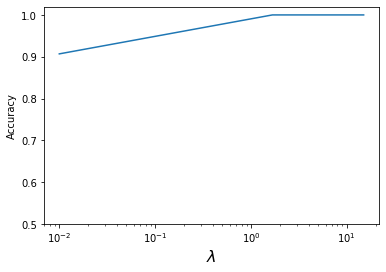

In [81]:
# plt.plot(lambda_vals, train_error, label="Train error")
# plt.plot(lambda_vals, test_error, label="Test error")
plt.plot(lambda_vals, train_acc)#, label="Train acc")
# plt.plot(lambda_vals, test_acc, label="Test acc")
plt.ylim(0.5,1.02)
plt.xscale('log')
# plt.legend(loc='lower right')
plt.xlabel(r"$\lambda$", fontsize=16)
plt.ylabel("Accuracy")
plt.savefig("lambda.png")

### Plot the regularization path for beta.

In [48]:
lambda_vals

array([1.00000000e-03, 2.33572147e-03, 5.45559478e-03, 1.27427499e-02,
       2.97635144e-02, 6.95192796e-02, 1.62377674e-01, 3.79269019e-01,
       8.85866790e-01, 2.06913808e+00, 4.83293024e+00, 1.12883789e+01,
       2.63665090e+01, 6.15848211e+01, 1.43844989e+02, 3.35981829e+02,
       7.84759970e+02, 1.83298071e+03, 4.28133240e+03, 1.00000000e+04])

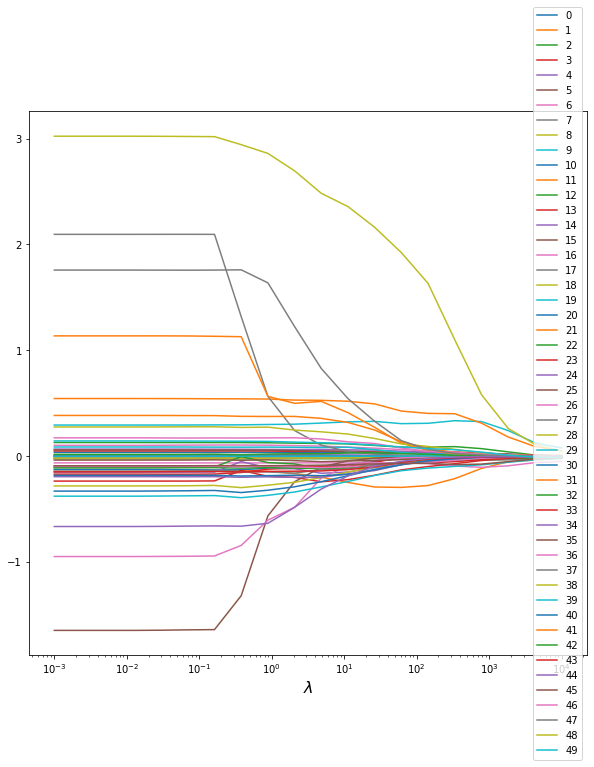

In [49]:
plt.figure(figsize=(10,10))
for i in range(n):
    plt.plot(lambda_vals, [wi[i,0] for wi in x_vals], label=str(i))
#     plt.ylim(-300, 300)
plt.legend(loc='right')
plt.xlabel(r"$\lambda$", fontsize=16)
plt.xscale("log")

### Optimization for the best parameter LAMBDA

In [51]:
m, n = X_train.shape

x = cp.Variable((n+1, 1))
lambd = cp.Parameter(nonneg=True)
loss = cp.sum(cp.pos(1 + A_train*x))
reg = cp.sum_squares(x)
prob = cp.Problem(cp.Minimize(loss + lambd*reg))

lambd.value = best_lambda

prob.solve(verbose=True, solver='ECOS')


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +3.701e+02  +4.123e+03  +5e+05  9e-01  2e-02  1e+00  1e+01    ---    ---    1  1  - |  -  - 
 1  +2.995e+03  +5.943e+03  +4e+05  6e-01  2e-02  2e+00  9e+00  0.3379  3e-01   1  2  2 |  0  0
 2  +5.889e+03  +8.275e+03  +3e+05  4e-01  2e-02  3e+00  7e+00  0.3439  3e-01   2  3  2 |  0  0
 3  +8.664e+03  +1.005e+04  +2e+05  2e-01  9e-03  3e+00  4e+00  0.5953  3e-01   2  2  2 |  0  0
 4  +9.320e+03  +9.708e+03  +5e+04  9e-02  3e-03  9e-01  1e+00  0.7477  6e-02   2  2  2 |  0  0
 5  +1.108e+04  +1.131e+04  +3e+04  6e-02  2e-03  6e-01  7e-01  0.4811  2e-01   2  3  3 |  0  0
 6  +1.254e+04  +1.268e+04  +2e+04  4e-02  1e-03  4e-01  4e-01  0.4706  1e-01   3  3  3 |  0  0
 7  +1.341e+04  +1.351e+04  +1e+04  3e-02  7e-04  3e-01  3e-01  0.3814  2e-01   3  4  4 |  0  0
 8  +1.397e+04  +1.405e+04  +9e+03  2e-02  5e-

16091.99514704822

In [52]:
y_pred_tr = np.sign(A_train.dot(x.value))
y_pred_te = np.sign(A_test.dot(x.value))

train_error = (y_train != y_pred_tr).sum()/len(y_train)
test_error = (y_test != y_pred_te).sum()/len(y_test)

train_acc = accuracy_score(y_train, y_pred_tr)
test_acc = accuracy_score(y_test, y_pred_te)

print("train\n", confusion_matrix(y_train, y_pred_tr))
print("\ntest\n", confusion_matrix(y_test, y_pred_te))

print("\nACC: \ntrain = {}, \ntest {}".format(train_acc, test_acc))


train
 [[13985     0]
 [    0  7949]]

test
 [[6015    0]
 [   0 3386]]

ACC: 
train = 1.0, 
test 1.0


In [53]:
x.value

array([[-3.13328624e-03],
       [-2.02480478e-02],
       [-1.62815845e-03],
       [ 5.12159320e-03],
       [-2.81332761e-04],
       [-1.29629937e-02],
       [-3.50115183e-03],
       [-7.40012560e-03],
       [ 5.22415913e-04],
       [ 2.75394258e-04],
       [ 1.36126877e-04],
       [-1.23975562e-03],
       [-1.50646113e-02],
       [-3.31987664e-04],
       [ 2.58390407e-03],
       [ 5.86526541e-05],
       [-4.91285019e-02],
       [-1.93144623e-02],
       [-6.13112076e-03],
       [ 7.68254390e-02],
       [-1.02276175e-03],
       [ 5.01649094e-02],
       [-1.60098510e-02],
       [ 6.79714795e-04],
       [-2.36154887e-03],
       [-5.00000059e-05],
       [-4.99999728e-05],
       [ 5.00000039e-05],
       [-6.87713777e-04],
       [-2.19323767e-02],
       [ 4.87840547e-03],
       [ 8.00000064e-04],
       [-5.16085205e-03],
       [-4.39796100e-03],
       [-8.99999925e-04],
       [-3.06769537e-03],
       [-3.41517146e-03],
       [-1.25000348e-03],
       [ 1.3

### Plot decision function

In [30]:
# TODO : wrong / omitted weights of other features 

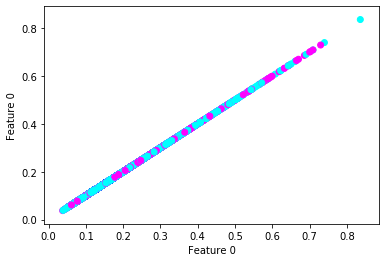

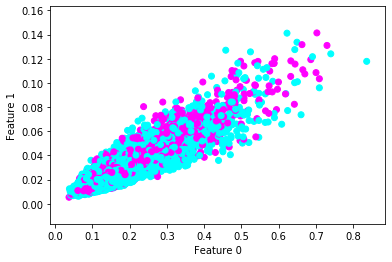

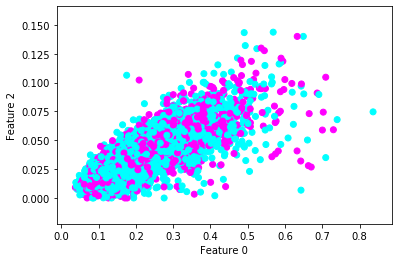

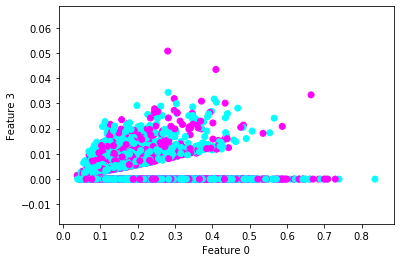

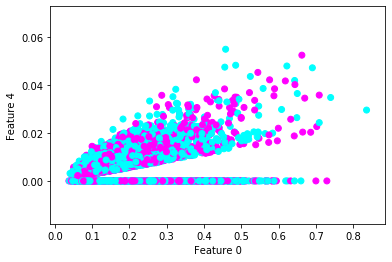

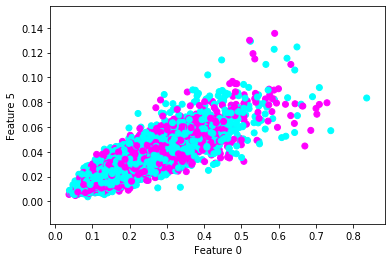

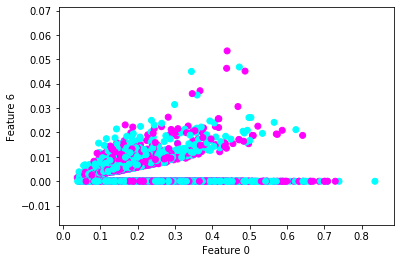

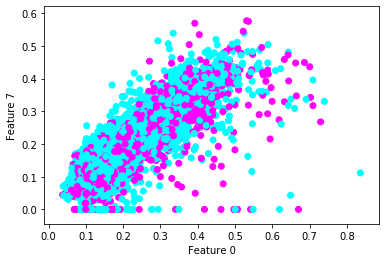

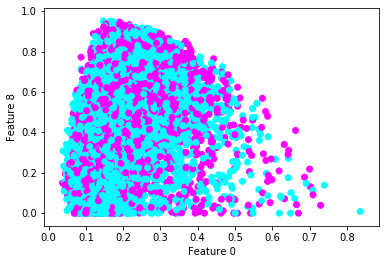

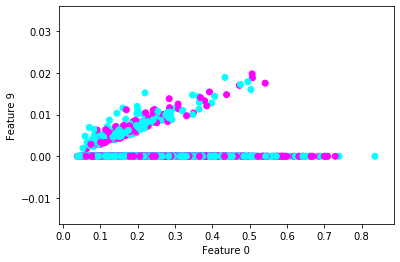

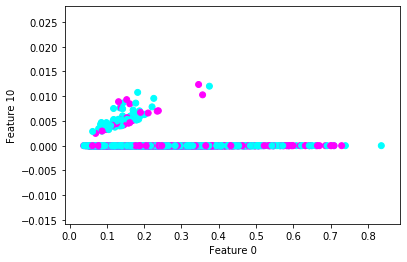

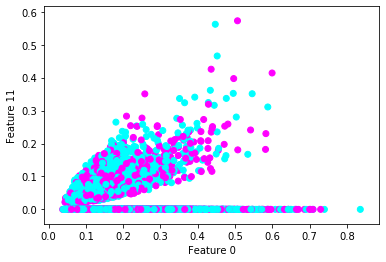

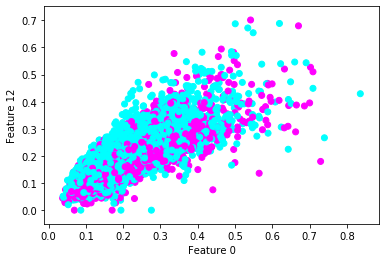

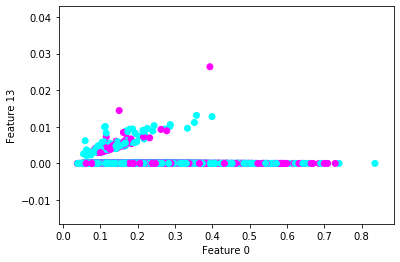

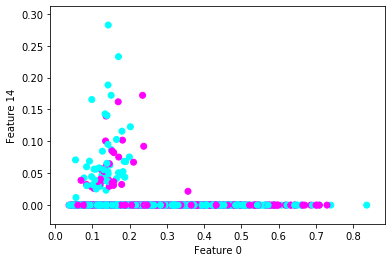

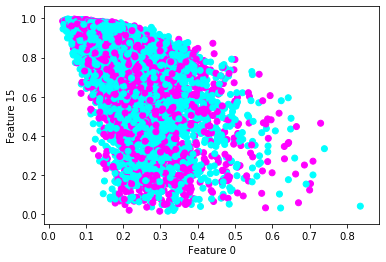

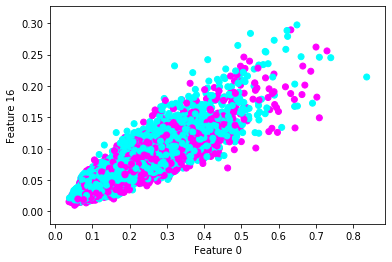

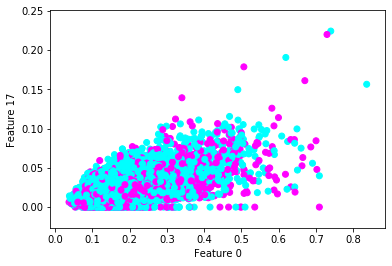

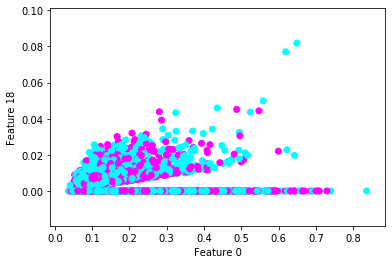

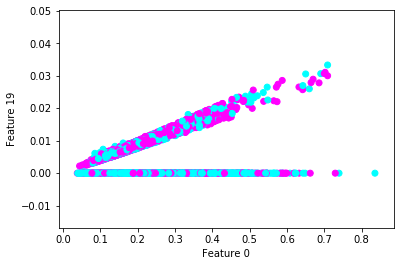

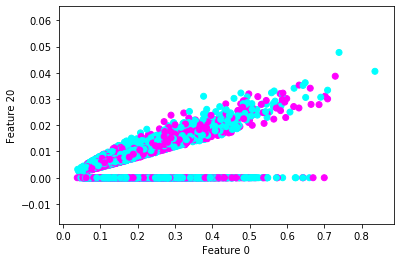

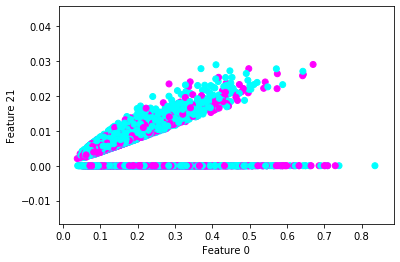

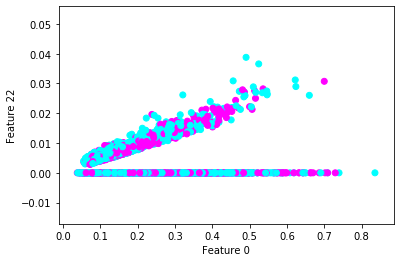

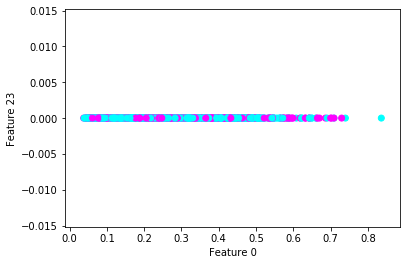

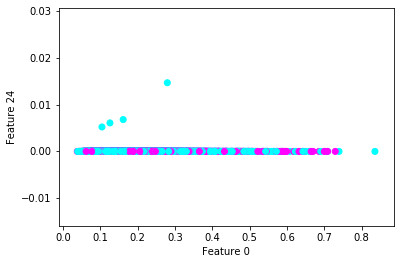

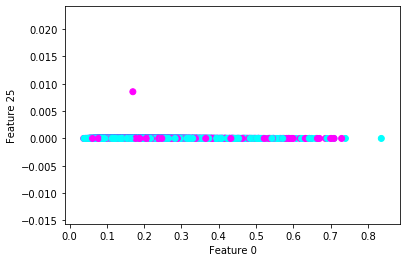

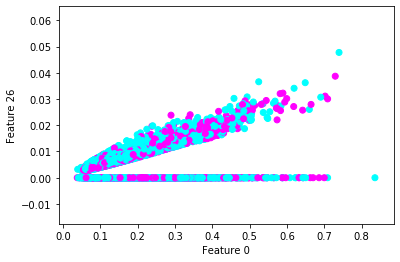

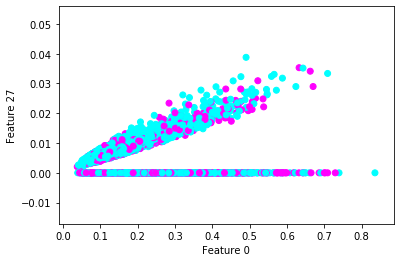

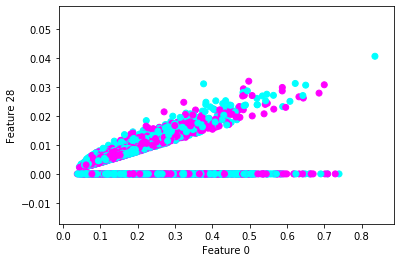

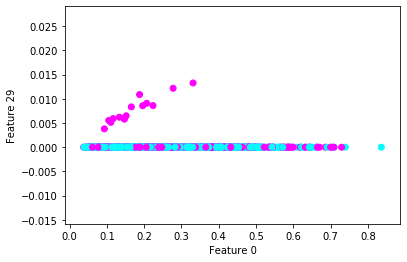

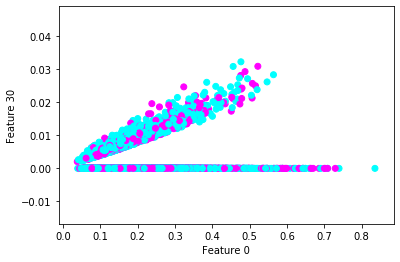

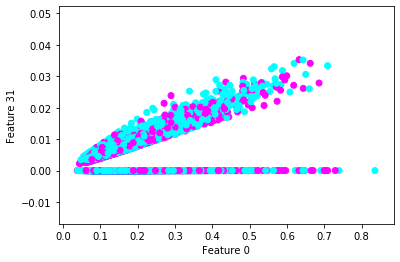

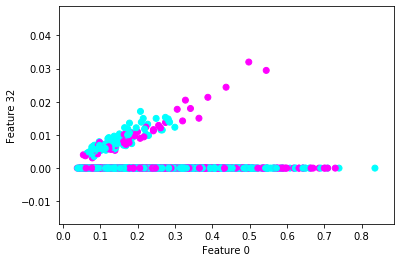

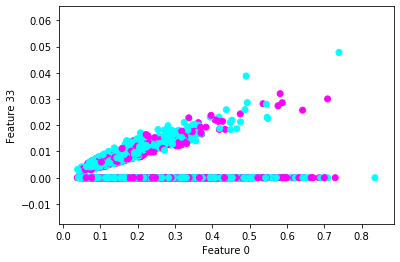

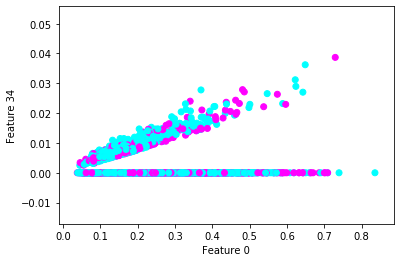

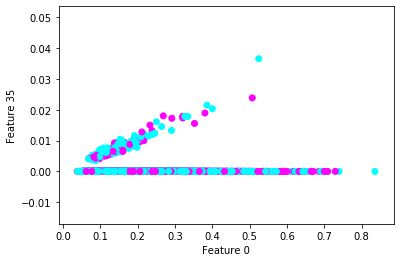

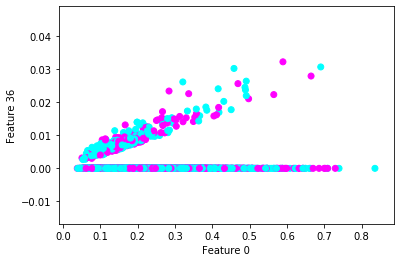

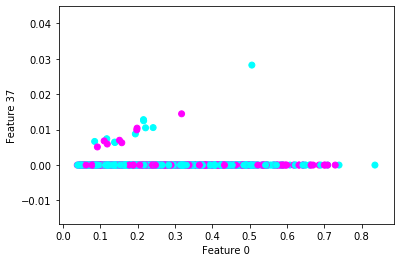

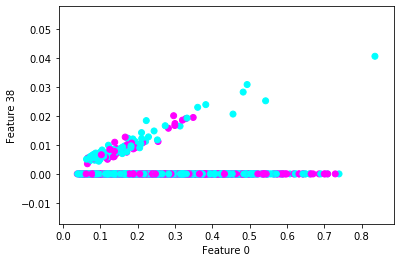

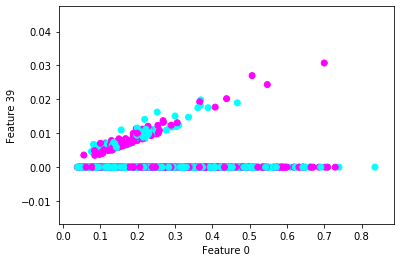

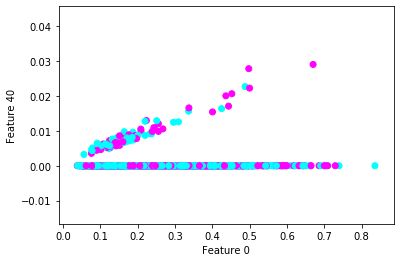

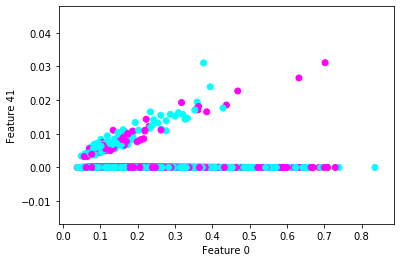

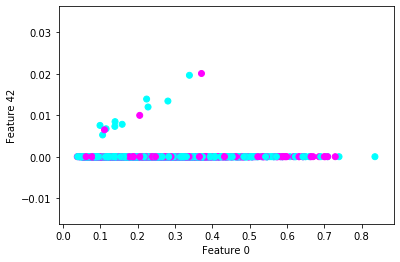

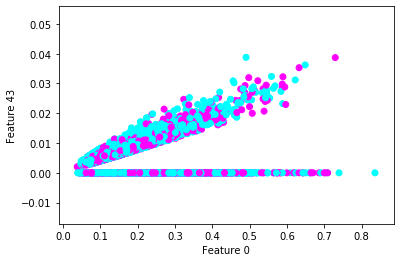

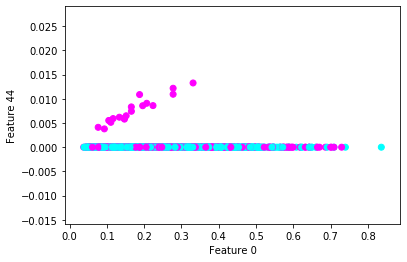

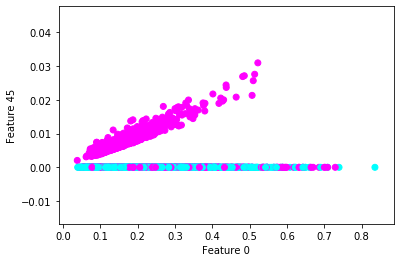

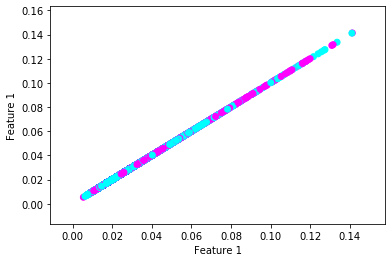

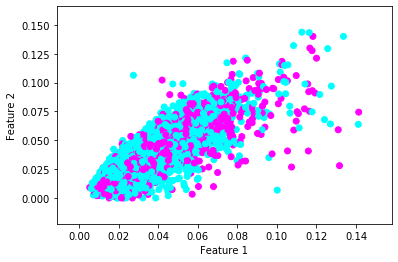

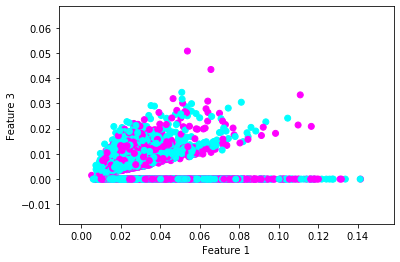

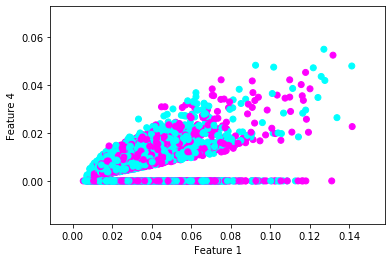

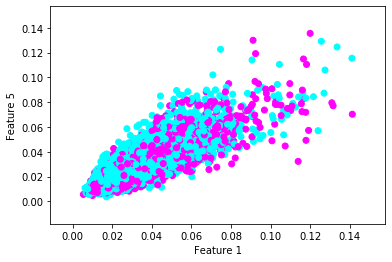

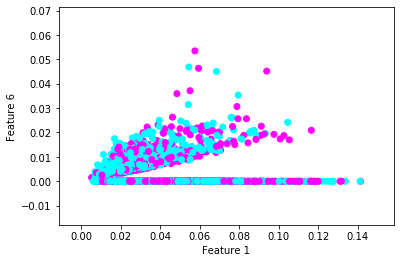

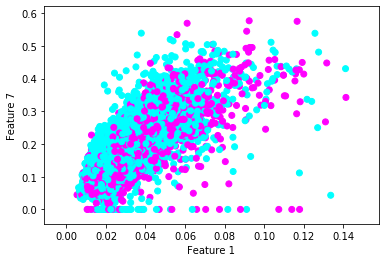

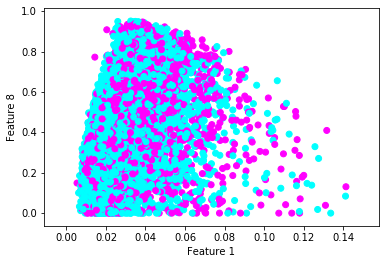

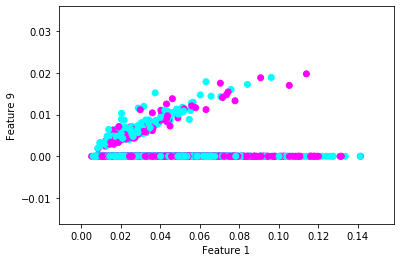

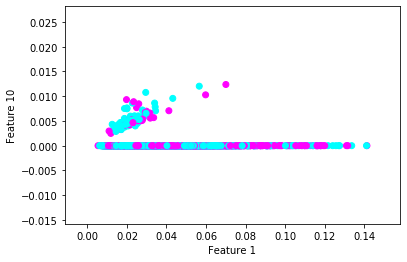

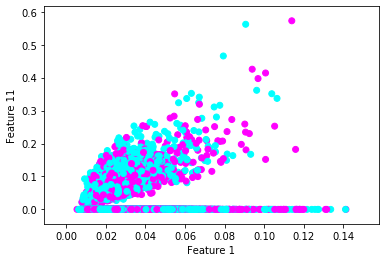

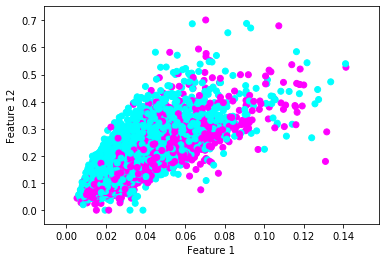

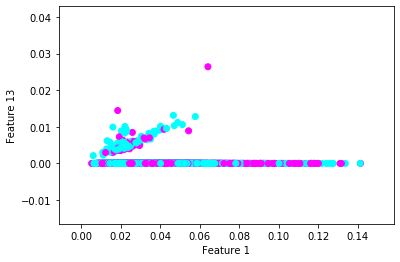

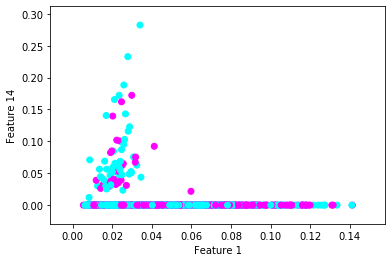

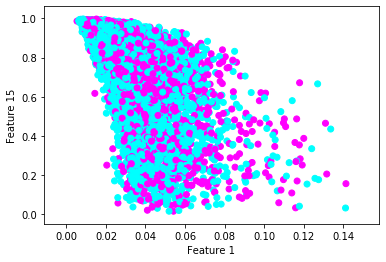

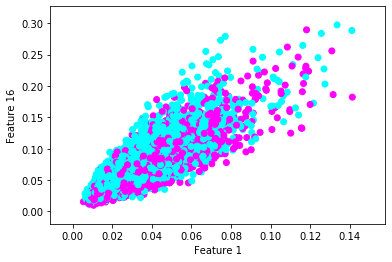

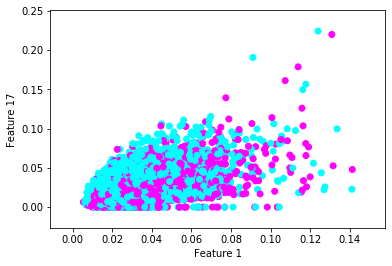

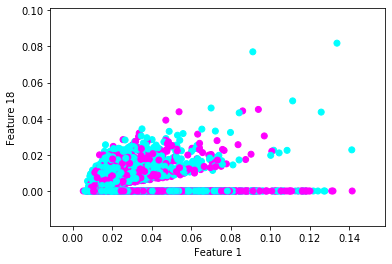

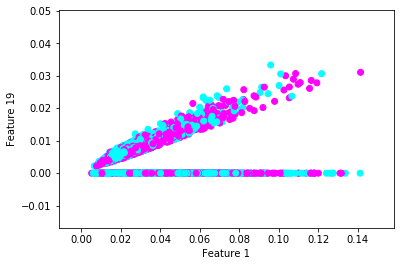

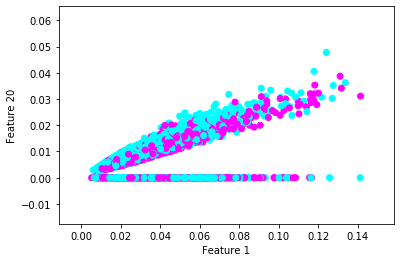

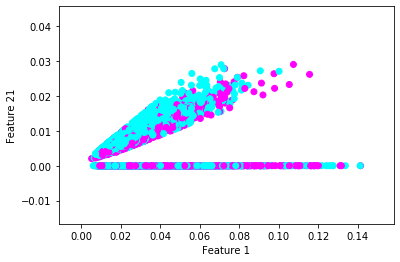

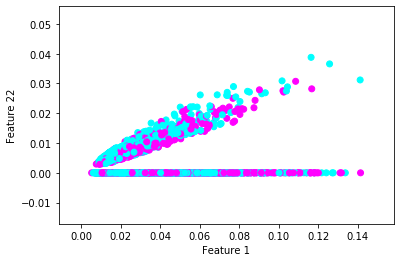

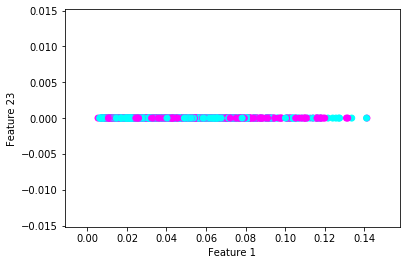

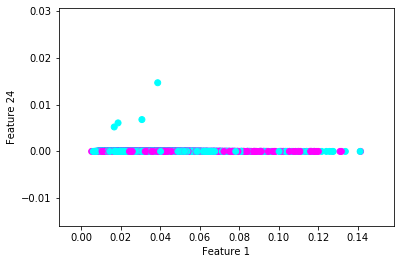

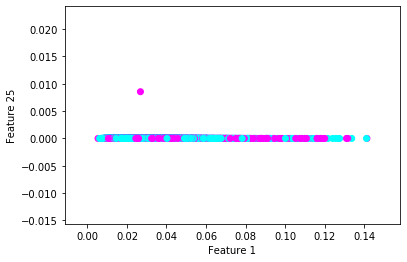

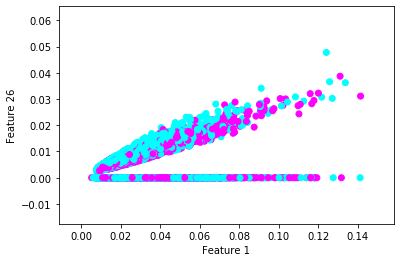

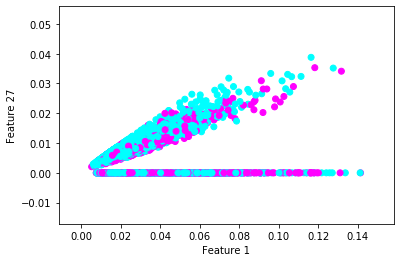

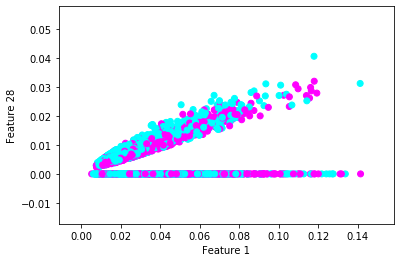

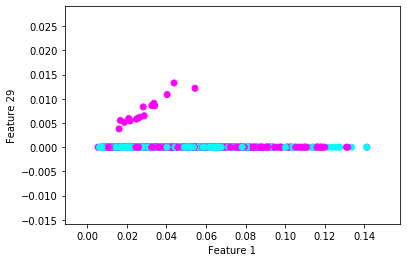

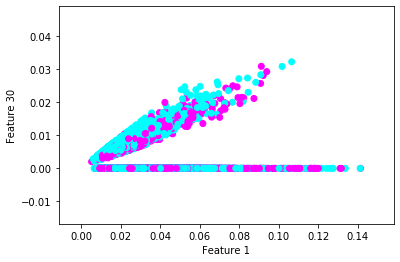

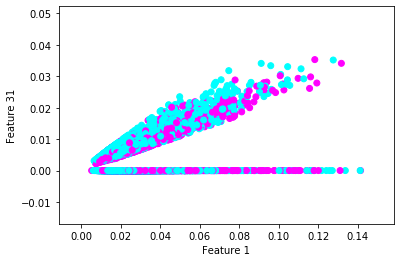

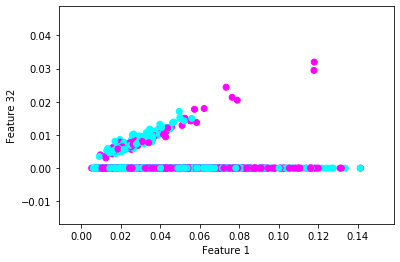

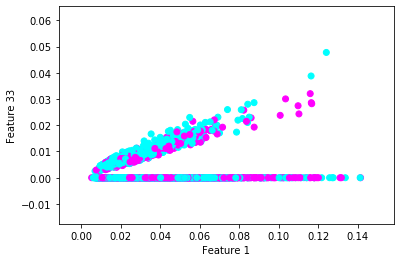

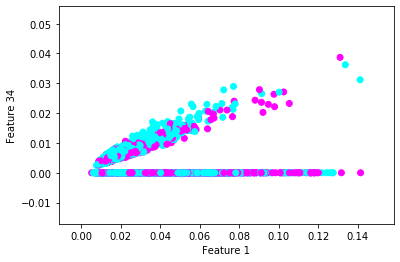

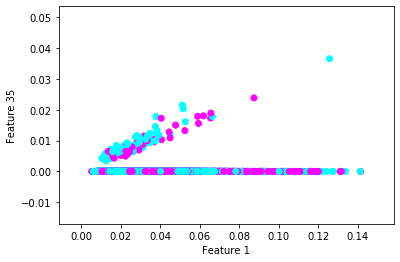

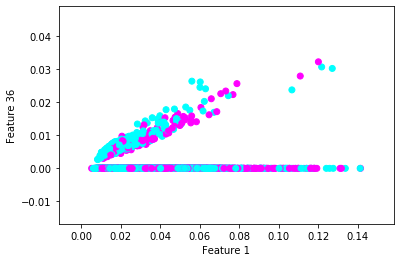

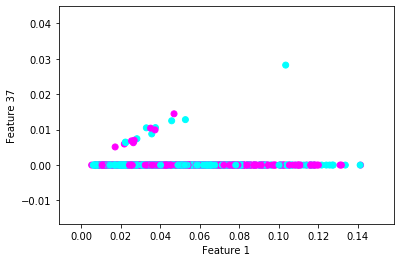

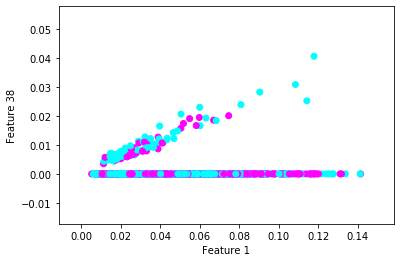

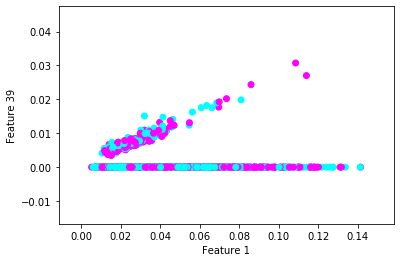

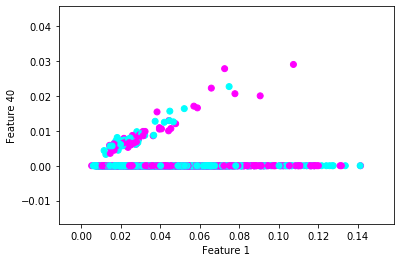

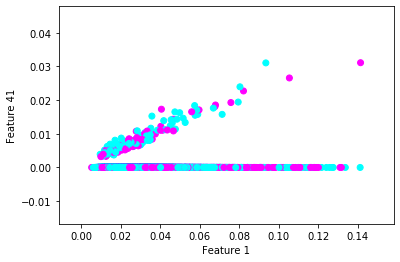

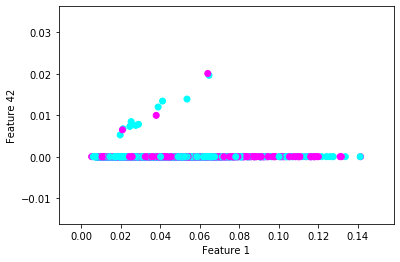

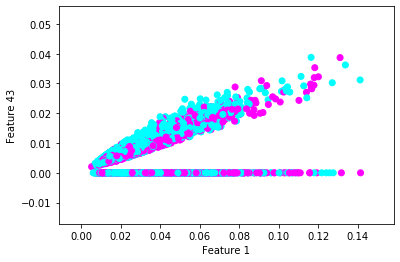

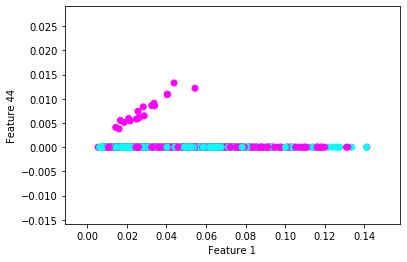

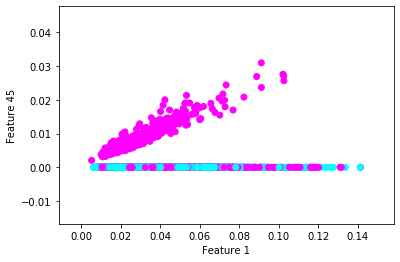

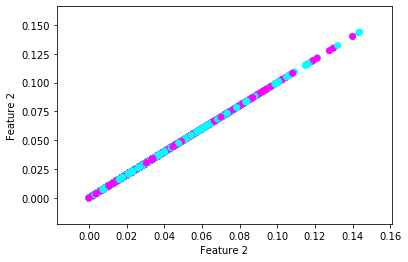

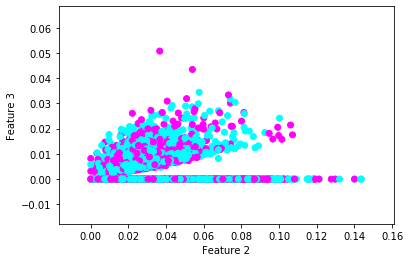

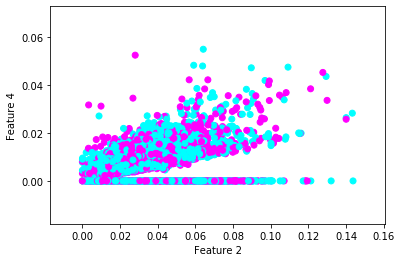

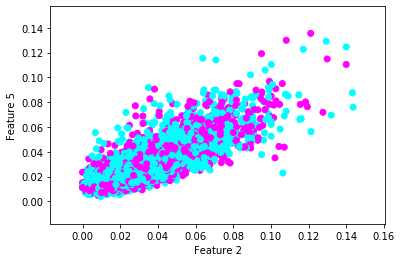

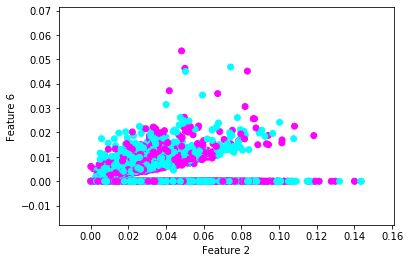

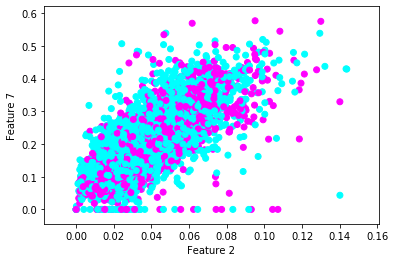

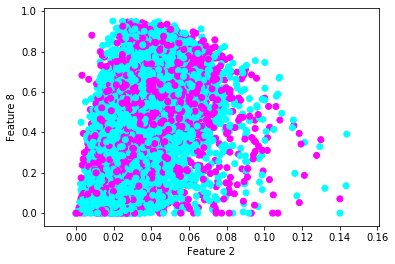

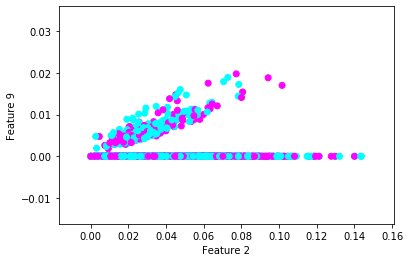

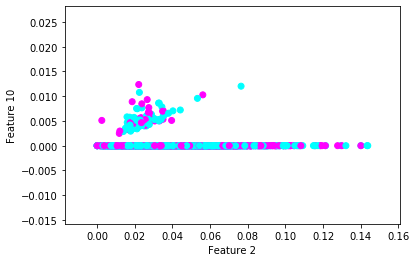

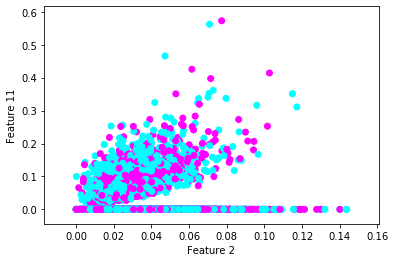

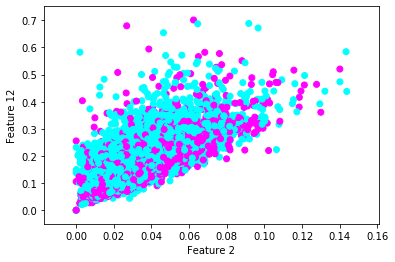

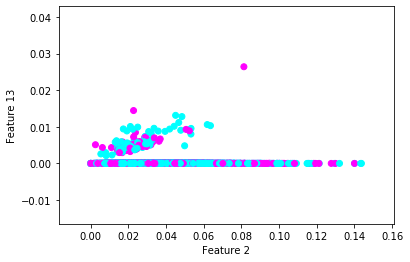

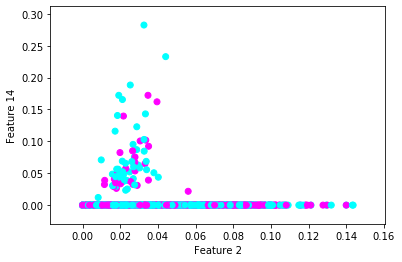

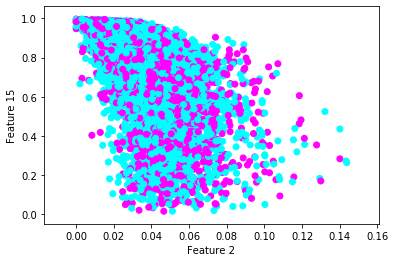

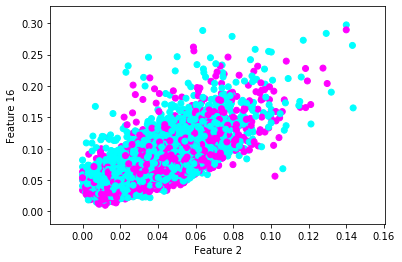

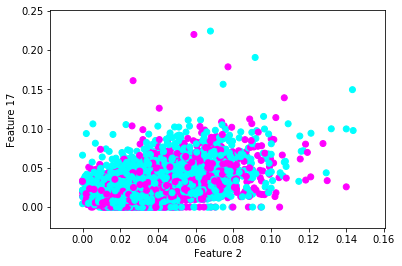

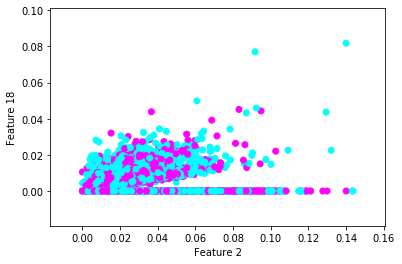

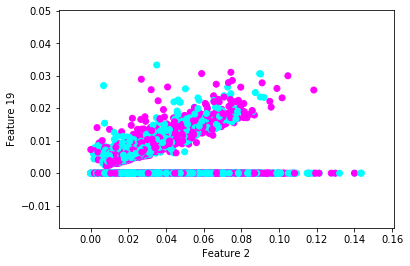

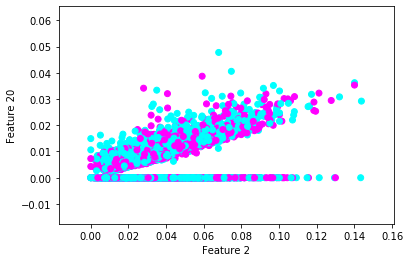

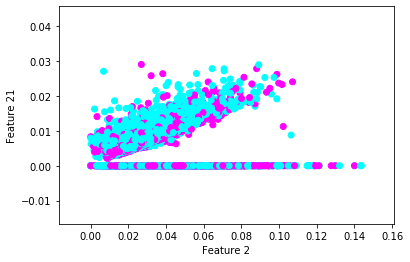

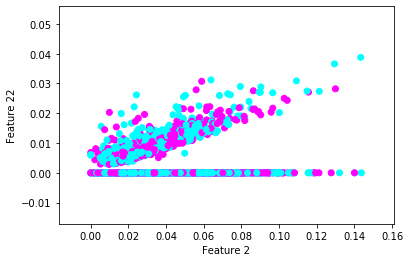

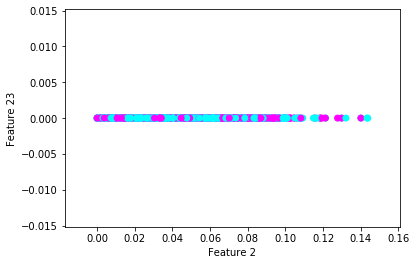

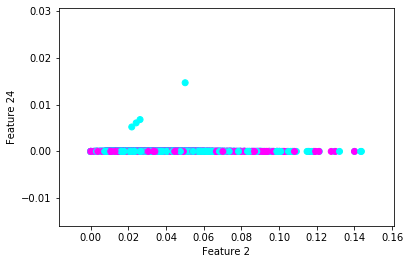

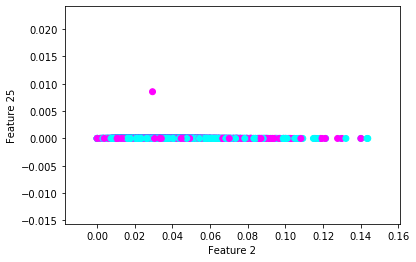

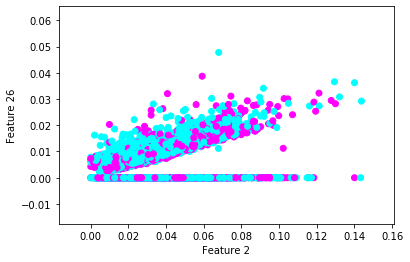

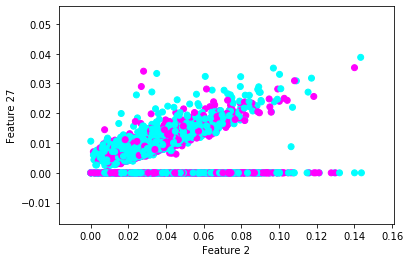

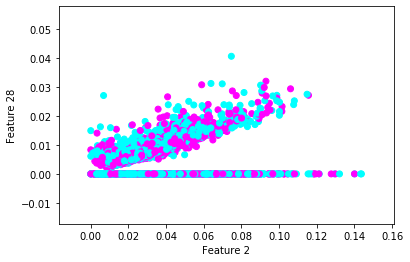

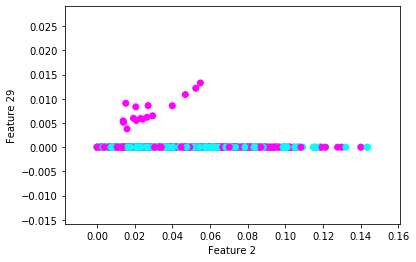

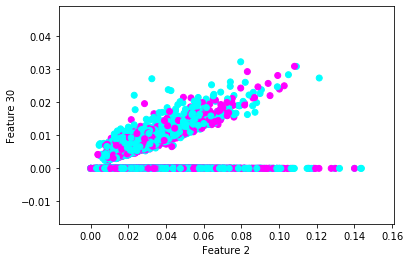

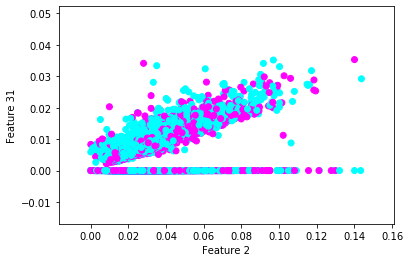

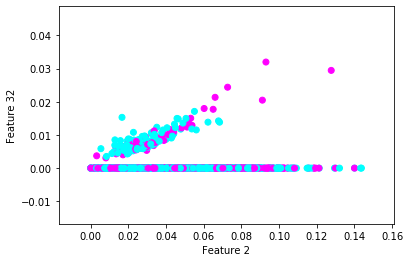

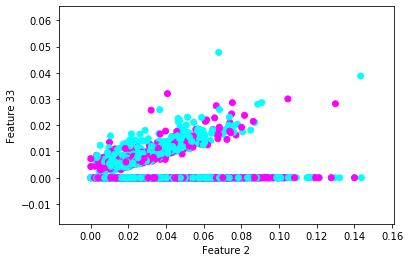

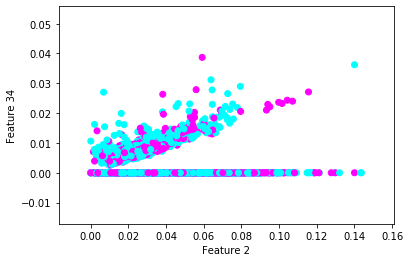

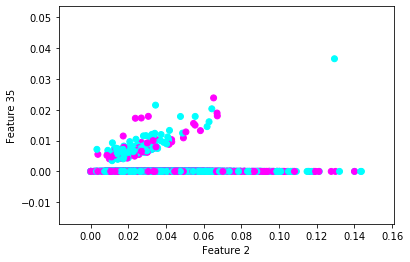

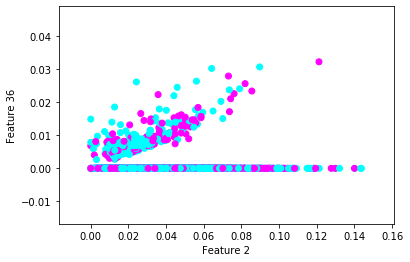

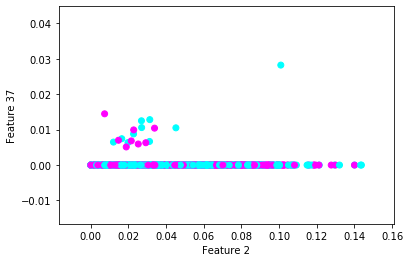

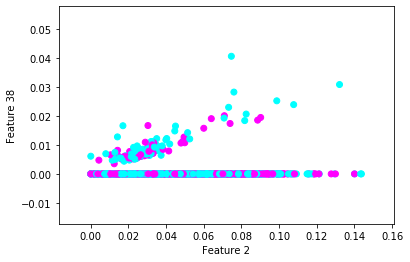

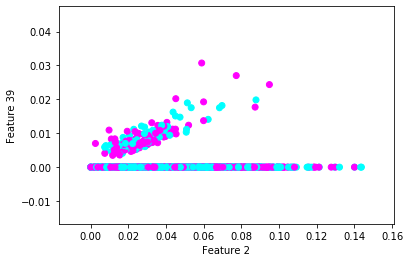

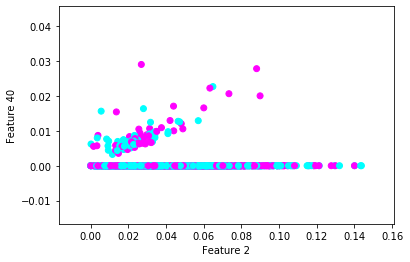

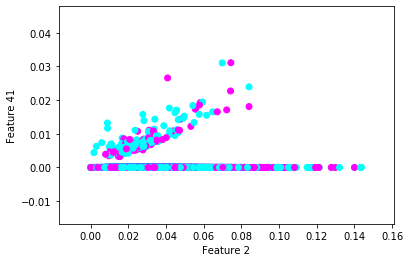

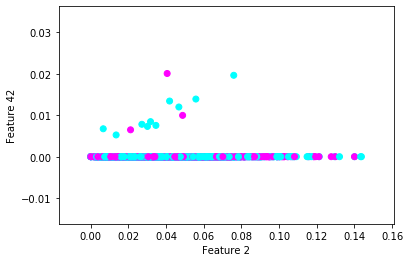

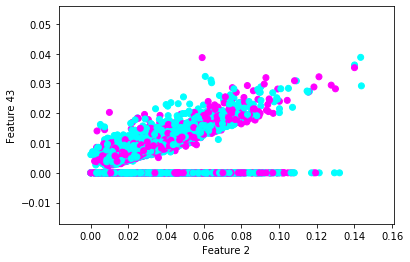

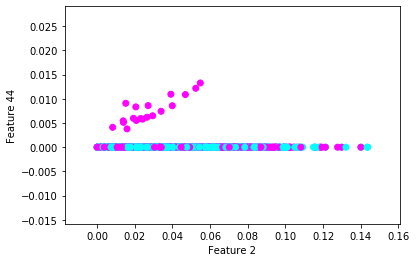

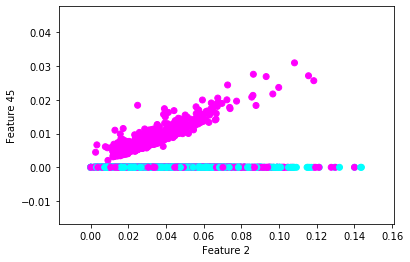

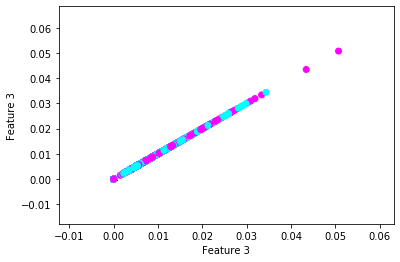

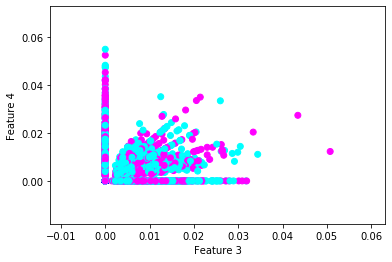

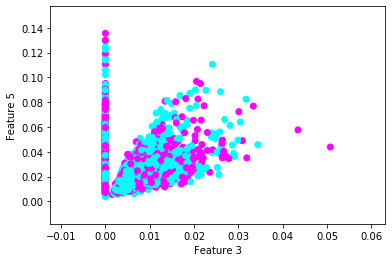

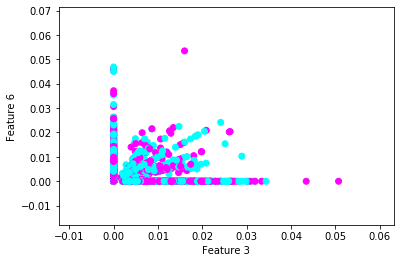

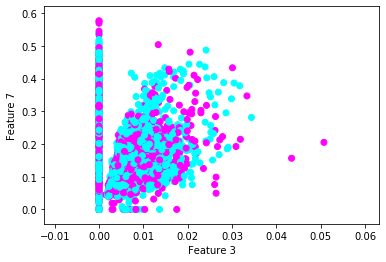

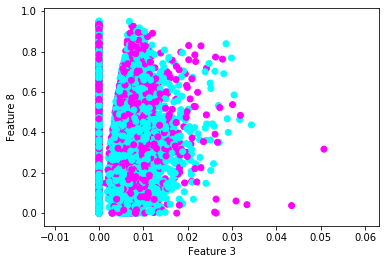

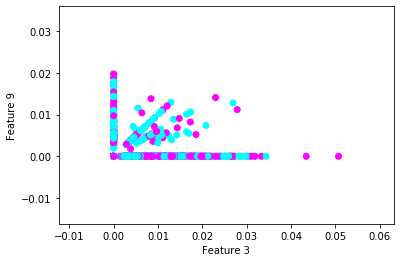

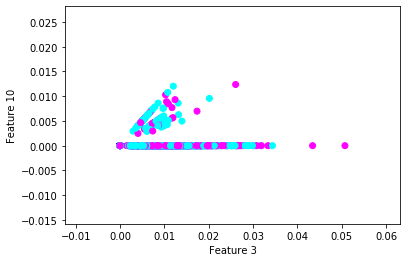

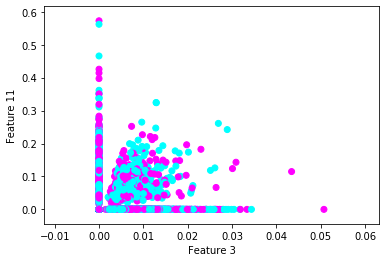

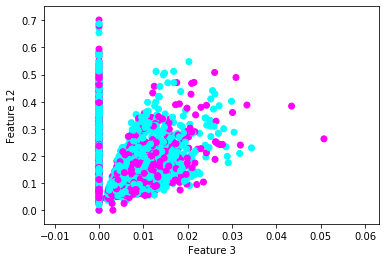

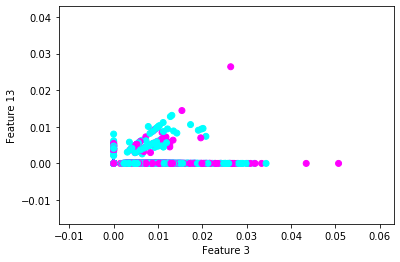

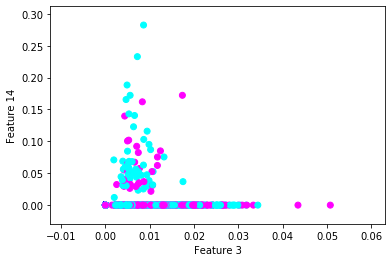

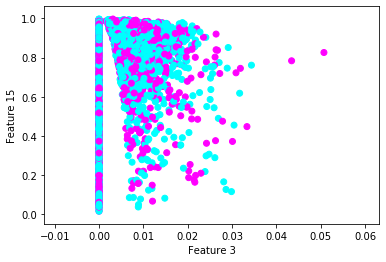

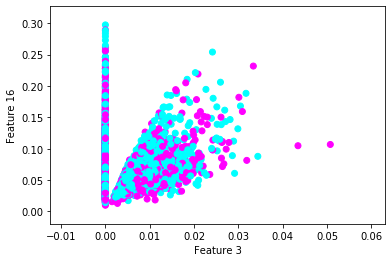

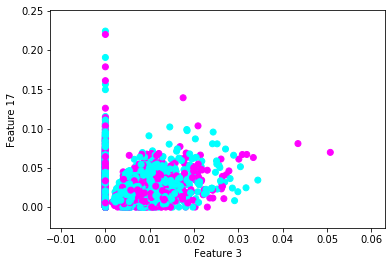

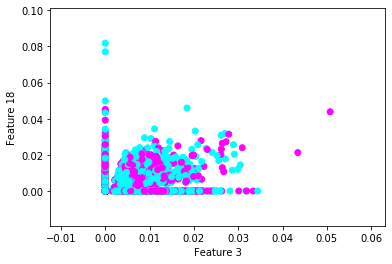

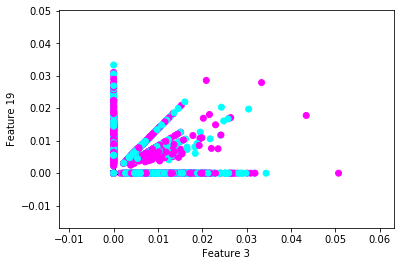

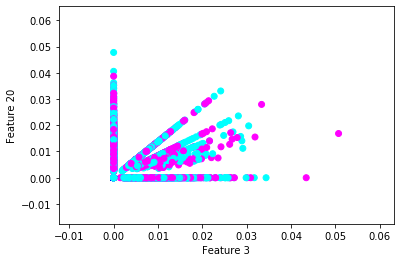

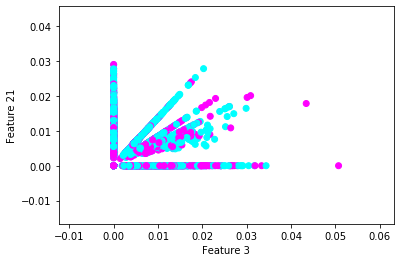

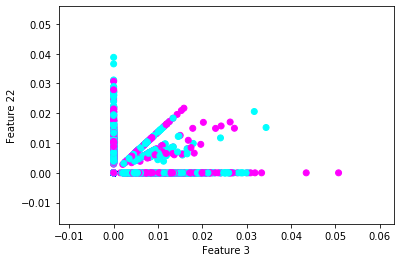

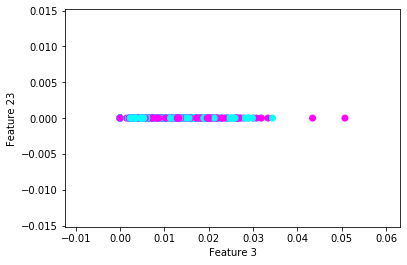

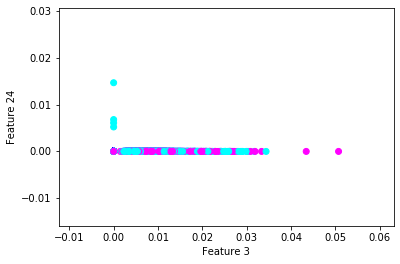

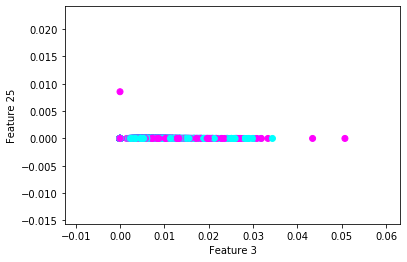

KeyboardInterrupt: 

In [33]:
# PredVal = X_train.dot(beta.value)

weights = beta.value
b = v.value

colors = [int(i) for i in y_train]
pairs = [(i,j) for i in range(len(weights)) for j in range(i, len(weights))]

for (i, j) in pairs:
    w1, w2 = weights[i], weights[j]

    plt.scatter(X_train[:,i], X_train[:,j], c=colors, cmap=plt.cm.cool)

#     minx = min(X_train[:, i])
#     maxx = max(X_train[:, i])
     
#     xx = np.linspace(minx, maxx)
#     yy = (-w1 / w2) * xx - b/w2 

    # Plot the hyperplane
    plt.plot(xx, yy.reshape(-1,1))
    plt.xlabel("Feature {}".format(i))
    plt.ylabel("Feature {}".format(j))
    plt.show()

In [ ]:
# from imblearn.over_sampling import SMOTE

# sm = SMOTE(sampling_strategy='minority')
# x_train_res, y_train_res = sm.fit_sample(X_train, y_train)

# # Shuffle dataset
# indexes = np.arange(len(x_train_res))
# np.random.shuffle(indexes)

# X = x_train_res[indexes]
# Y = np.array(y_train_res[indexes]).reshape(-1, 1)